## Libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import color,io ,img_as_ubyte , feature
from skimage.feature import graycomatrix,graycoprops
from skimage.measure import shannon_entropy
from scipy.stats import describe
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from google.colab import drive
import random
#drive.mount('/content/drive')


## Loading & scaling the dataset 

In [2]:
#here we read the data from the dataset and divid the person's name in label images in images
def load_data(dataset_path):
    images = []
    labels = []
    sums=0
    for person_name in os.listdir(dataset_path):
        sums+=1
        counts=0
        person_path = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_path):
            for filename in os.listdir(person_path):
                img_path = os.path.join(person_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (227, 227))
                    img=img/255.0
                    images.append(img)
                    labels.append(person_name)
                    counts+=1

                else:
                    print(f"Error loading image: {img_path}")
    print(sums)
    return np.array(images), np.array(labels)
dataset_path = 'datasetpro2'
images, labels = load_data(dataset_path)



56


## Data description and statistical analysis 

- Contrast:
Measures the local variations in intensity, highlighting the presence of sharp transitions between pixel values.

- Homogeneity:
Represents the closeness of pixel intensities in an image, emphasizing regions with more uniform texture.

- Energy (or Angular Second Moment):
Quantifies the orderliness or randomness of pixel pairs in the image. Higher energy values indicate more order.

- Correlation:
Describes the linear dependency between pixel pairs, indicating the degree to which pixel values change in a specific direction.

In [3]:
def calculate_glcm_features():
  all_features = []
  all_labels = []

  # Take only 5 file paths
  image_files = [dataset_path +'/Jennifer_Aniston/Jennifer_Aniston_0001.jpg',
                          dataset_path +'/David_Beckham/David_Beckham_0001.jpg',
                          dataset_path +'/Jennifer_Lopez/Jennifer_Lopez_0001.jpg',
                          dataset_path +'/Naomi_Watts/Naomi_Watts_0001.jpg',
                          dataset_path +'/Mahmoud_Abbas/Mahmoud_Abbas_0001.jpg']
  # Process each image
  for image_file in image_files:
    print("Processing :",image_file, "\n")
    # Load the image
    combined_image = io.imread(image_file)
    combined_image_unit8 = img_as_ubyte(combined_image)
    img_gray = img_as_ubyte(color.rgb2gray(combined_image_unit8 ))
    glcm = graycomatrix(img_gray, [1], [0], symmetric=True, normed=True)
    # Extract GLCM features
    contrast = np.mean (feature.graycoprops(glcm, 'contrast' ))
    correlation = np.mean( feature. graycoprops (glcm, 'correlation'))
    energy = np.mean (feature.graycoprops (glcm,  'energy'))
    homogeneity = np.mean(feature.graycoprops (glcm,'homogeneity'))
    # Display GLCM features
    print (f"Contrast: {contrast}")
    print(f"Correlation: {correlation}'")
    print (f"Energy: {energy}")
    print(f"Homogeneity: {homogeneity}")
    print("------------------------------------------")

In [4]:
calculate_glcm_features()


Processing : datasetpro2/Jennifer_Aniston/Jennifer_Aniston_0001.jpg 

Contrast: 52.82094779116467
Correlation: 0.9928719980364992'
Energy: 0.03957919979283347
Homogeneity: 0.3324100979801532
------------------------------------------
Processing : datasetpro2/David_Beckham/David_Beckham_0001.jpg 

Contrast: 109.98923694779117
Correlation: 0.985556512391996'
Energy: 0.06411349430953038
Homogeneity: 0.37218360889567526
------------------------------------------
Processing : datasetpro2/Jennifer_Lopez/Jennifer_Lopez_0001.jpg 

Contrast: 38.93529317269077
Correlation: 0.994461584666742'
Energy: 0.03451389079667594
Homogeneity: 0.3958302533671094
------------------------------------------
Processing : datasetpro2/Naomi_Watts/Naomi_Watts_0001.jpg 

Contrast: 60.585285140562256
Correlation: 0.9915704805308135'
Energy: 0.029132336347782086
Homogeneity: 0.27746362898026755
------------------------------------------
Processing : datasetpro2/Mahmoud_Abbas/Mahmoud_Abbas_0001.jpg 

Contrast: 37.4656

## Encoding the labels

In [5]:

# Split the data into training and testing sets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(labels)
# Now, x_train, y_train, x_test, y_test contain the split datasets
x_train, x_test, y_train, y_test = train_test_split(images, y_train, test_size=0.2, random_state=42)
# If you want to check the shapes of the arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
#print( x_train[0])
#print( y_train[0])
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (2293, 227, 227, 3)
y_train shape: (2293,)
x_test shape: (574, 227, 227, 3)
y_test shape: (574,)


## Visulisation

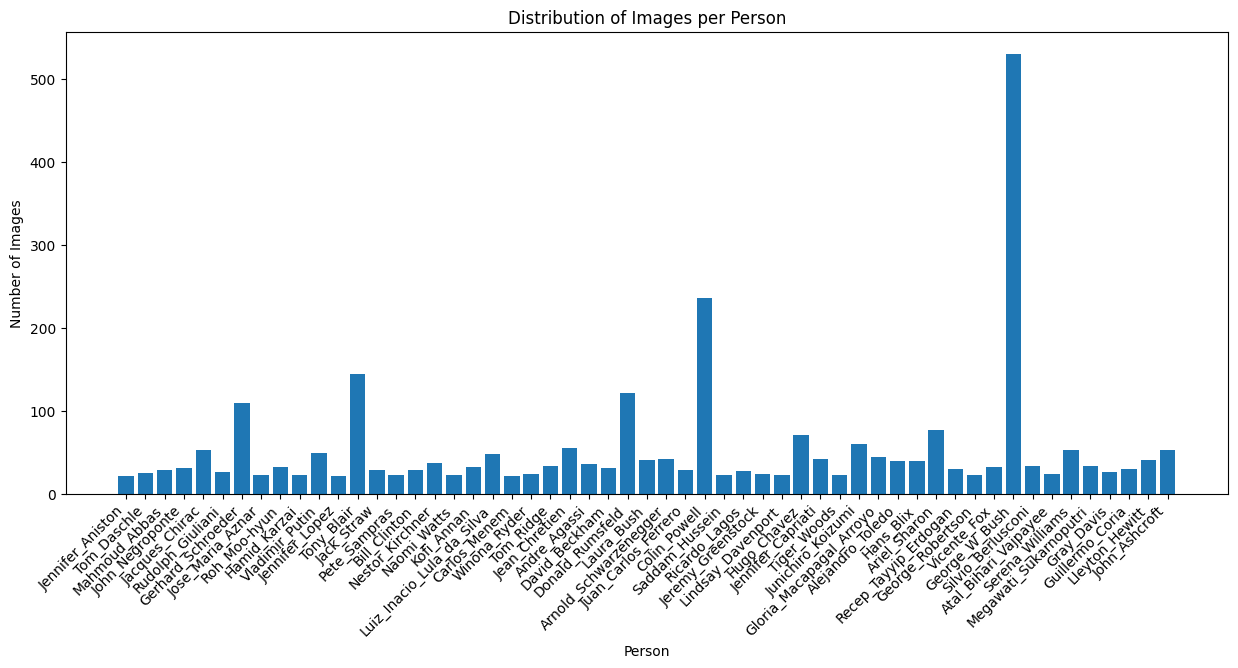

In [6]:
# Count the number of images per person
image_counts = {}
for person_name in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person_name)
    if os.path.isdir(person_folder):
        image_counts[person_name] = len(os.listdir(person_folder))

# Plot the distribution
plt.figure(figsize=(15, 6))
plt.bar(image_counts.keys(), image_counts.values())
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Person')
plt.xticks(rotation=45, ha='right')
plt.show()


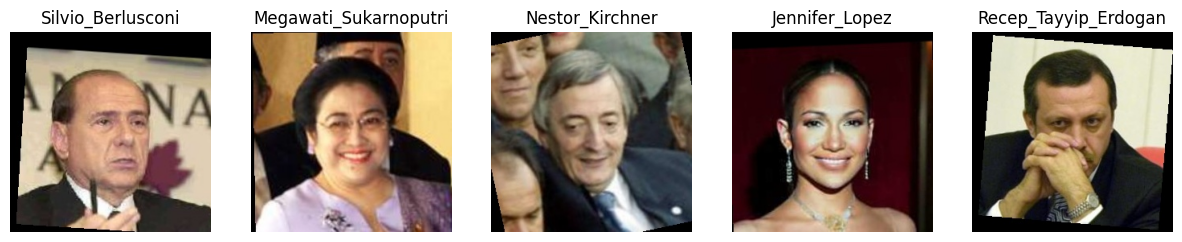

In [7]:
# Display sample images from different people
plt.figure(figsize=(15, 8))
for i, person_name in enumerate(random.sample(os.listdir(dataset_path), 5)):
    person_folder = os.path.join(dataset_path, person_name)
    if os.path.isdir(person_folder):
        random_image = random.choice(os.listdir(person_folder))
        img_path = os.path.join(person_folder, random_image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(person_name)
        plt.axis('off')

plt.show()


Pixel intensity refers to the brightness of a pixel in a digital image. In grayscale, it ranges from 0 (black) to 255 (white). In color images, it's represented by RGB values. Analyzing pixel intensity is crucial for tasks like edge detection, contrast adjustment, and image processing. Understanding these variations enables the extraction of features and information from visual content.

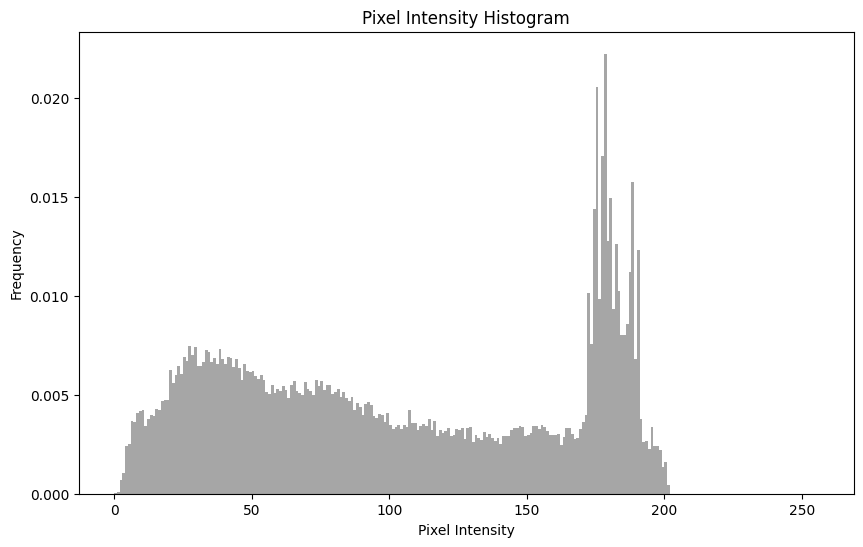

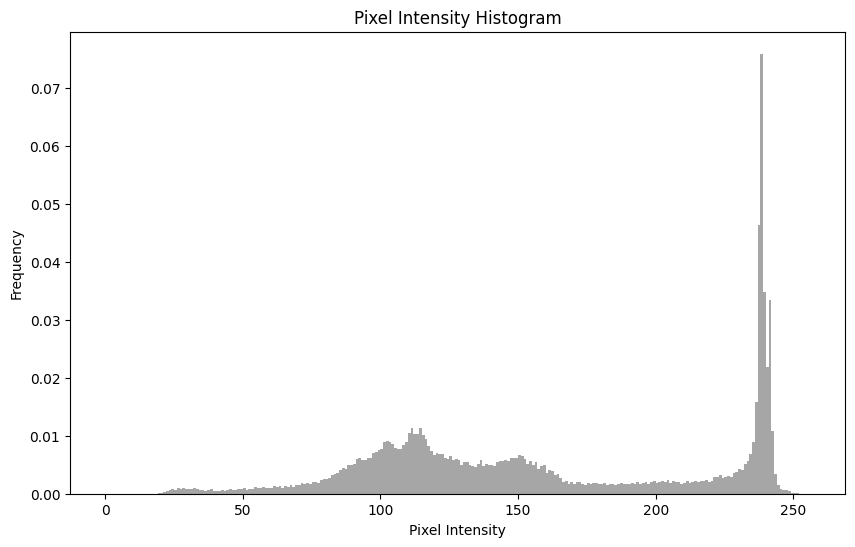

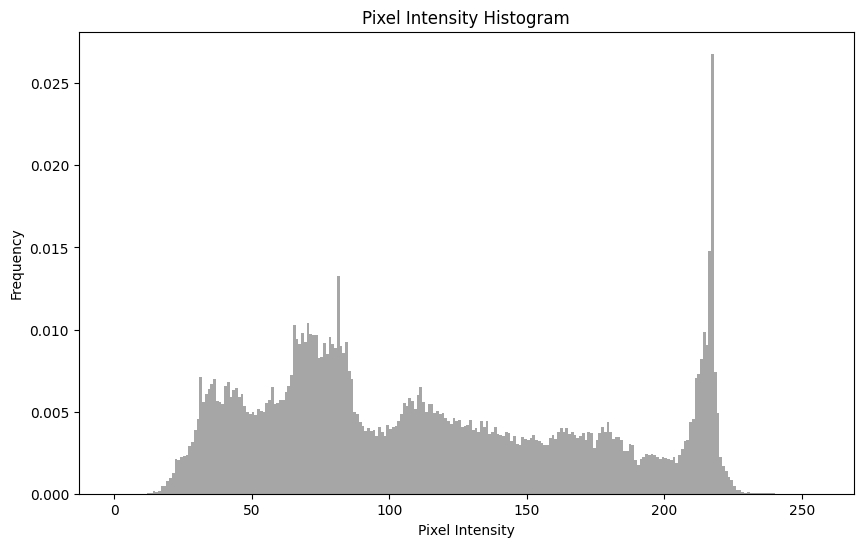

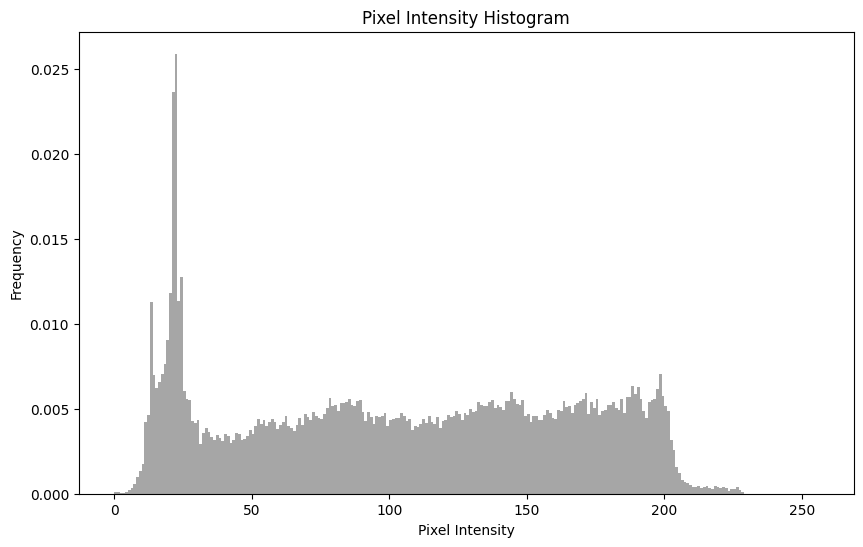

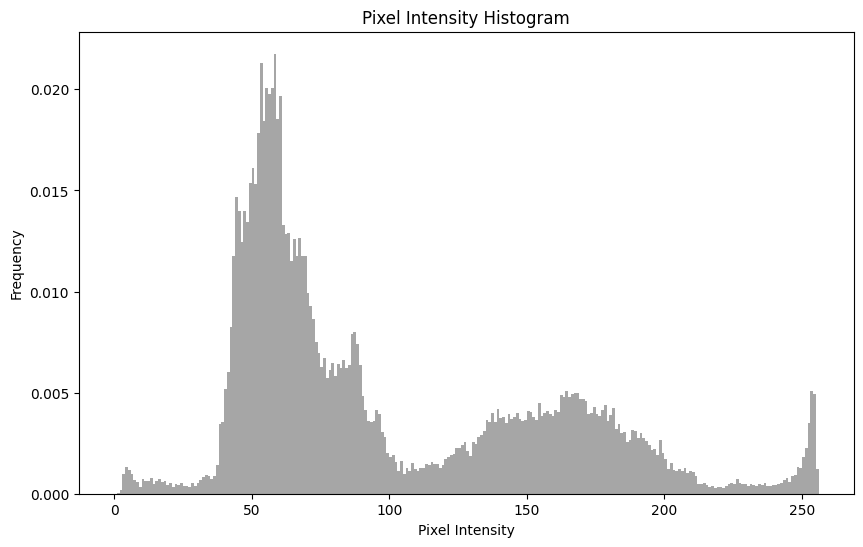

In [8]:
image_files = [dataset_path +'/Jennifer_Aniston/Jennifer_Aniston_0001.jpg',
                          dataset_path +'/David_Beckham/David_Beckham_0001.jpg',
                          dataset_path +'/Jennifer_Lopez/Jennifer_Lopez_0001.jpg',
                          dataset_path +'/Naomi_Watts/Naomi_Watts_0001.jpg',
                          dataset_path +'/Mahmoud_Abbas/Mahmoud_Abbas_0001.jpg']
for image_file in image_files:
  # Read the image
  img = cv2.imread(image_file)

  # Convert the image to grayscale (assuming it's a color image)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Flatten the image array to a 1D array
  pixels = gray_img.flatten()

  # Plot the histogram
  plt.figure(figsize=(10, 6))
  plt.hist(pixels, bins=256, range=[0, 256], density=True, color='gray', alpha=0.7)
  plt.title('Pixel Intensity Histogram')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.show()


## Alexnet

AlexNet is a convolutional neural network (CNN) architecture designed for image classification tasks. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton and won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012, marking a breakthrough in deep learning.

Key Features of AlexNet:

- Architecture:
AlexNet consists of eight layers, including five convolutional layers and three fully connected layers. It follows a pattern of convolutional layers followed by max-pooling layers.

- Rectified Linear Units (ReLU):
ReLU activation functions are used after each convolutional layer, introducing non-linearity to the network.

- Local Response Normalization (LRN):
LRN is applied after some of the convolutional layers, promoting local competition between neurons.

- Dropout:
AlexNet employs dropout in the fully connected layers to reduce overfitting during training.

- Data Augmentation:
Data augmentation techniques, such as cropping and flipping, were used to artificially increase the size of the training dataset, contributing to improved generalization.

- Large-Scale Training:
AlexNet was trained on a large dataset, ImageNet, containing millions of labeled images across thousands of categories.

- Parallelization:
Training of AlexNet was made efficient through the use of two GPUs in parallel, a practice that became common in subsequent deep learning models.

- Achievements:
AlexNet significantly outperformed previous models in the ILSVRC 2012, reducing the top-5 error rate by a substantial margin.

![alexnet.jpg](./alexnet.png)


In [9]:
# Building the AlexNet Model Architecture
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(55, activation='softmax'))
# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [10]:
alexnet = model.fit(x_train, y_train, epochs=12, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/12
144/144 [==============================] - 61s 422ms/step - loss: 7.3383 - accuracy: 0.1291 - val_loss: 18.1160 - val_accuracy: 0.0941
Epoch 2/12
144/144 [==============================] - 61s 424ms/step - loss: 5.4218 - accuracy: 0.2551 - val_loss: 5.7184 - val_accuracy: 0.1882
Epoch 3/12
144/144 [==============================] - 61s 425ms/step - loss: 3.2846 - accuracy: 0.3969 - val_loss: 5.2792 - val_accuracy: 0.2753
Epoch 4/12
144/144 [==============================] - 60s 415ms/step - loss: 1.6832 - accuracy: 0.5901 - val_loss: 3.2022 - val_accuracy: 0.3519
Epoch 5/12
144/144 [==============================] - 60s 416ms/step - loss: 0.9679 - accuracy: 0.7174 - val_loss: 2.6864 - val_accuracy: 0.4599
Epoch 6/12
144/144 [==============================] - 59s 412ms/step - loss: 0.6061 - accuracy: 0.8160 - val_loss: 2.6970 - val_accuracy: 0.4530
Epoch 7/12
144/144 [==============================] - 59s 410ms/step - loss: 0.3963 - accuracy: 0.8783 - val_loss: 4.5540 - val_a

In [11]:
#Model Evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


18/18 [==============================] - 4s 197ms/step - loss: 3.2557 - accuracy: 0.5296
Test Loss: 3.2557, Test Accuracy: 0.5296


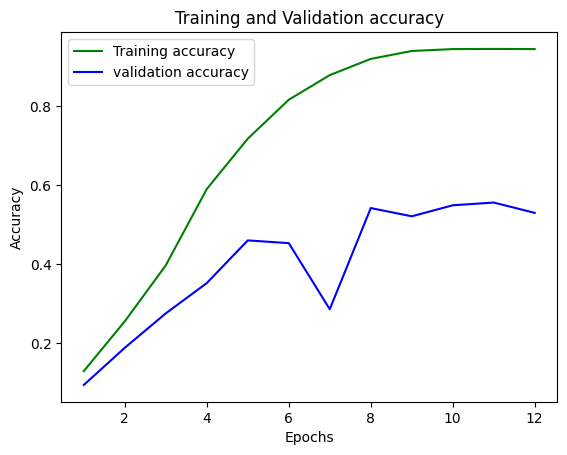

In [12]:
train_accuracy = alexnet.history['accuracy']
val_accuracy = alexnet.history['val_accuracy']
epochs = range(1,alexnet.epoch[-1]+2)
plt.plot(epochs, train_accuracy,'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Vggfaces

The VGG (Visual Geometry Group) architecture is a family of convolutional neural network (CNN) models that have been widely used for image classification tasks. The original VGG architecture, known as VGG16, was introduced by the Visual Geometry Group at Oxford University. It has a simple and uniform architecture with a focus on depth, using 3x3 convolutional filters throughout the network.

If "VGGFaces" is a term used in the context of facial recognition, it might refer to a customized or fine-tuned version of the VGG architecture for face-related tasks. Researchers and practitioners often adapt existing CNN architectures for specific domains, and a model named "VGGFaces" could be designed or trained specifically for facial recognition.

![vgg.jpg](./vggface.png)


In [17]:
#here we read the data from the dataset and divid the person's name in label images in images
def load_data(dataset_path):
    images = []
    labels = []
    sums=0
    for person_name in os.listdir(dataset_path):
        sums+=1
        counts=0
        person_path = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_path):
            for filename in os.listdir(person_path):
                img_path = os.path.join(person_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (227, 227))
                    img=img/255.0
                    images.append(img)
                    labels.append(person_name)
                    counts+=1

                else:
                    print(f"Error loading image: {img_path}")
    print(sums)
    return np.array(images), np.array(labels)
dataset_path = 'datasetpro2'
images, labels = load_data(dataset_path)



56


In [18]:

# Split the data into training and testing sets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(labels)
# Now, x_train, y_train, x_test, y_test contain the split datasets
x_train, x_test, y_train, y_test = train_test_split(images, y_train, test_size=0.2, random_state=42)
# If you want to check the shapes of the arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
#print( x_train[0])
#print( y_train[0])
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (2293, 227, 227, 3)
y_train shape: (2293,)
x_test shape: (574, 227, 227, 3)
y_test shape: (574,)


In [19]:
# Building the vggface Model Architecture

model2 = Sequential()

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(227, 227, 3)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))
model2.add(Flatten())
model2.add(Dense(4096, activation='relu'))
model2.add(Dense(4096, activation='relu'))
model2.add(Dense(55, activation='softmax'))
# Compiling the Model
model2.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
# Display the model summary
model2.summary()


: 

In [16]:
vggfaces = model2.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/10
144/144 [==============================] - 2677s 19s/step - loss: 3.8559 - accuracy: 0.1736 - val_loss: 3.5861 - val_accuracy: 0.1603
Epoch 2/10
144/144 [==============================] - 1930s 13s/step - loss: 3.6060 - accuracy: 0.1910 - val_loss: 3.6076 - val_accuracy: 0.1603
Epoch 3/10
144/144 [==============================] - 1734s 12s/step - loss: 3.5803 - accuracy: 0.1910 - val_loss: 3.5724 - val_accuracy: 0.1603
Epoch 4/10
144/144 [==============================] - 5217s 36s/step - loss: 3.5734 - accuracy: 0.1910 - val_loss: 3.5712 - val_accuracy: 0.1603
Epoch 5/10
  2/144 [..............................] - ETA: 25:58 - loss: 3.3850 - accuracy: 0.2812

KeyboardInterrupt: 

In [ ]:
#Model Evaluation
loss, accuracy = model2.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [ ]:
train_accuracy = vggfaces.history['accuracy']
val_accuracy = vggfaces.history['val_accuracy']
epochs = range(1,vggfaces.epoch[-1]+2)
plt.plot(epochs, train_accuracy,'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusion 

- In wrapping up the project, we focused on using AlexNet for face verification. To boost our results, we also introduced VGG Face into the mix. While AlexNet performed well, the addition of VGG Face noticeably improved accuracy. This highlights the value of experimenting with different models to get the best outcomes. The project not only showcases AlexNet's capabilities but also emphasizes the practical advantage of including models like VGG Face for superior results in face verification tasks. This flexible approach sets the stage for future investigations into maximizing accuracy through the smart combination of various models.

-- AlexNet: the training accuracy started settling down on epoch 10 to 0.9442 and the max_validation accuarcy was 0.5557 at epoch 11
-- VGGfaces : the max_validation accuracy was 0.6 